#### MACHINE LEARNING ASSIGNMENT 1

Data analysis : Det data from DB

In [61]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///F24.ML.Assignment.One.data.db')

query = text('''
SELECT 
    oh.*,
    MAX(CASE WHEN op.NAME = 'region_id' THEN opv.VALUE END) AS region_id,
    MAX(CASE WHEN op.NAME = 'order_ready' THEN opv.VALUE END) AS order_ready_date,
    MAX(CASE WHEN op.NAME = 'order_start_prepare' THEN opv.VALUE END) AS order_start_prepare,
    MAX(CASE WHEN op.NAME = 'delivery_distance' THEN opv.VALUE END) AS delivery_distance,
    MAX(CASE WHEN op.NAME = 'profit' THEN opv.VALUE END) AS profit,
    MAX(CASE WHEN op.NAME = 'order_pickup' THEN opv.VALUE END) AS order_pickup_date,
    COUNT(DISTINCT ob.product_id) AS product_count,
    SUM(ob.price) AS total_price
FROM 
    order_history oh
LEFT JOIN order_props_value opv ON oh.order_id = opv.order_id
LEFT JOIN order_props op ON opv.ORDER_PROPS_ID = op.ID
LEFT JOIN order_busket ob ON oh.order_id = ob.order_id
LEFT JOIN products p ON ob.product_id = p.product_id AND oh.store_id = p.store_id
GROUP BY 
    oh.order_id
            ''')

with session_engine.connect() as conn: 
    order_df = pd.read_sql_query(query, conn) 
order_df.head()

,order_id,STATUS_ID,store_id,planned_prep_time,DATE_CREATE,region_id,order_ready_date,order_start_prepare,delivery_distance,profit,order_pickup_date,product_count,total_price
0,18671223,F,3750,35.0,2024-05-08 00:01:12,683,2024-05-08 00:25:12,2024-05-08 00:01:21,3934,20.145,08-05-2024 00:53:12,3,241.740
1,18671225,F,5863,15.0,2024-05-08 00:01:46,703,2024-05-08 00:10:29,2024-05-08 00:02:01,560,15.8,08-05-2024 00:38:29,1,189.600
2,18671227,F,8721,20.0,2024-05-08 00:01:38,691,2024-05-08 00:49:19,2024-05-08 00:01:50,4396,6.0040000000000004,08-05-2024 01:17:19,1,180.120
3,18671229,F,8929,30.0,2024-05-08 00:02:59,683,2024-05-08 00:22:04,2024-05-08 00:10:07,5499,40.29,08-05-2024 00:50:04,4,483.480
4,18671231,F,9007,25.0,2024-05-08 00:02:22,707,2024-05-08 00:36:25,2024-05-08 00:02:37,5411,122.73440000000001,08-05-2024 01:04:25,3,920.508


##### Data analysis: Data preprocessing and visualization

In [62]:
order_df.describe()

,order_id,store_id,planned_prep_time,product_count,total_price
count,5.176100e+05,517610.000000,517609.000000,517610.000000,502626.000000
mean,1.962557e+07,6681.590711,23.241360,2.607593,481.599973
std,5.474842e+05,2710.745860,8.301033,1.565553,387.373876
min,1.867122e+07,3053.000000,0.000000,1.000000,24.174000
25%,1.914967e+07,4008.000000,20.000000,1.000000,237.000000
50%,1.963311e+07,6205.000000,20.000000,2.000000,381.570000
75%,2.009969e+07,9217.000000,30.000000,3.000000,608.142000
max,2.056276e+07,11965.000000,180.000000,31.000000,12044.340000


In [63]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             517610 non-null  int64  
 1   STATUS_ID            517610 non-null  object 
 2   store_id             517610 non-null  int64  
 3   planned_prep_time    517609 non-null  float64
 4   DATE_CREATE          517337 non-null  object 
 5   region_id            517610 non-null  object 
 6   order_ready_date     466244 non-null  object 
 7   order_start_prepare  465814 non-null  object 
 8   delivery_distance    517610 non-null  object 
 9   profit               466225 non-null  object 
 10  order_pickup_date    517610 non-null  object 
 11  product_count        517610 non-null  int64  
 12  total_price          502626 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 51.3+ MB


In [64]:
# from ydata_profiling import ProfileReport

# report = ProfileReport(order_df)
# report.to_file('order_df_report.html')

### Feature Engineering

First Convert object to numeric where necessary

Then Convert date columns to datetime where necessary (parse dates not working as expected)

In [65]:
cols_to_convert = ['region_id', 'delivery_distance', 'profit']
parse_dates=['DATE_CREATE','order_ready_date','order_start_prepare','order_pickup_date']

for col in cols_to_convert:
    order_df[col] = pd.to_numeric(order_df[col])
for col in parse_dates:
    order_df[col] = pd.to_datetime(order_df[col],format='mixed')

In [66]:
order_df.isna().sum()

order_id                   0
STATUS_ID                  0
store_id                   0
planned_prep_time          1
DATE_CREATE              273
region_id                  0
order_ready_date       51366
order_start_prepare    51796
delivery_distance          0
profit                 51385
order_pickup_date          0
product_count              0
total_price            14984
dtype: int64

#### Handle nulls
1. Drop null rows for `DATE_CREATE`
1. Fill with mean value for `planned_prep_time`
2. Fill `order_start_prepare` 
    - Find mean difference between that and `order_created` for each `store_id` 
    - if `order_start_prepare` is null, put `order_created` + mean time difference of that store
3. For `order_ready_date` maybe fill with averge of (`order_created` - `order_ready_date`) or (`order_start_prepare` - `order_ready_date`) for each store
4. For `total_price` and `profit` used KNNImputer

In [67]:
# 1. drop date_create null row
order_df.dropna(subset='DATE_CREATE',inplace=True)

In [68]:
# 2. Fill with mean value for planned_prep_time
'''fill 1 null value in planned_prep_time using interquantile mean, 
because 75% of the data has a range between 20 - 30'''

order_df['planned_prep_time'] = order_df.planned_prep_time.fillna(order_df.planned_prep_time.mean())

Duplicate `order_df` for task2

In [69]:
order_df_task_2: pd.DataFrame = order_df

### Split before other pre-processing steps to avoid data leak

In [70]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

order_df.sort_values(by='DATE_CREATE',inplace=True)
order_train, order_test = train_test_split(order_df,shuffle=False,test_size=.1)

#### 3. Fill `order_start_prepare` using mean time_diff for each store in train set
calculate mean time_diff for each store in train set

In [71]:
order_train['time_diff_start']  = order_train.order_start_prepare - order_train.DATE_CREATE
# Find the mean time difference for each store_id
mean_time_train_start = order_train.groupby('store_id')['time_diff_start'].mean()

function to apply this mean to a DF

In [72]:
def fill_order_start_prepare(df:pd.DataFrame):
    # Fill missing values in 'order_start_prepare' using 'DATE_CREATE' + mean time difference for that store
    df['order_start_prepare'] = df.apply(
        lambda row: row['DATE_CREATE'] + mean_time_train_start.get(row['store_id'],pd.Timedelta(0)) 
                    if pd.isna(row['order_start_prepare']) else row['order_start_prepare'],
        axis=1
    )

#### 4. Fill `order_ready_date`
calculate mean time_diff for each store in train set

In [73]:
order_train['time_diff_ready'] = order_train.order_ready_date - order_train.DATE_CREATE
# df['time_diff']  = df.order_ready_date - df.order_start_prepare
#Find the mean time difference for each store_id
mean_time_train_ready = order_train.groupby('store_id')['time_diff_ready'].mean()
mean_time_train_ready

store_id
3053    0 days 00:30:42.033530571
3055    0 days 00:17:48.171428571
3056    0 days 00:24:55.156794425
3058    0 days 00:29:51.742275810
3059    0 days 00:25:06.187250996
                   ...           
11867   0 days 00:05:00.416666666
11875             0 days 00:13:08
11877      0 days 00:20:06.062500
11879   0 days 00:11:11.083333333
11885             0 days 00:26:39
Name: time_diff_ready, Length: 1387, dtype: timedelta64[ns]

function to apply this mean to a dataframe

In [74]:
def fill_order_ready_date(df:pd.DataFrame):
    # Fill missing values in 'order_ready_date' using 'DATE_CREATE' + mean time difference for that store
    df['order_ready_date'] = df.apply(
        lambda row: row['DATE_CREATE'] + mean_time_train_ready.get(row['store_id'], pd.Timedelta(0)) 
                    if pd.isna(row['order_ready_date']) else row['order_ready_date'],
        axis=1
    )

In [75]:
fill_order_start_prepare(order_train)
fill_order_ready_date(order_train)

fill_order_start_prepare(order_test)
fill_order_ready_date(order_test)

# Drop the time_diff column
order_train.drop(columns=['time_diff_ready'],inplace=True)
order_train.drop(columns=['time_diff_start'],inplace=True)

In [76]:
# drop data where order_ready_date is before order_start_prepare
def drop_corrupted_data(df:pd.DataFrame):
    corrupted_data = df[df['order_ready_date'] < df['order_start_prepare']]
    df.drop(corrupted_data.index,inplace=True)

drop_corrupted_data(order_train)
drop_corrupted_data(order_test)
order_df[order_df['order_ready_date'] < order_df['order_start_prepare']]

,order_id,STATUS_ID,store_id,planned_prep_time,DATE_CREATE,region_id,order_ready_date,order_start_prepare,delivery_distance,profit,order_pickup_date,product_count,total_price
45,18671395,F,7963,5.0,2024-05-08 00:20:59,683,2024-05-08 00:42:27,2024-05-08 01:35:26,7747,112.4960,2024-08-05 01:10:27,2,843.720
499,18673245,F,11007,10.0,2024-05-08 11:06:53,683,2024-05-08 11:31:31,2024-05-08 11:34:48,1139,52.2980,2024-08-05 11:59:31,4,1260.840
570,18673507,F,9991,11.0,2024-05-08 11:26:44,683,2024-05-08 11:46:47,2024-05-08 12:37:49,2606,8.3582,2024-08-05 12:14:47,1,250.746
575,18673521,F,3527,25.0,2024-05-08 11:37:48,691,2024-05-08 11:46:28,2024-05-08 11:46:33,1810,44.2400,2024-08-05 12:14:28,2,331.800
1105,18675435,F,8211,10.0,2024-05-08 12:56:19,693,2024-05-08 13:17:49,2024-05-08 14:16:34,9403,21.0140,2024-08-05 13:45:49,7,630.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
516122,20557341,F,3376,5.0,2024-09-05 02:17:17,683,2024-09-05 02:47:17,2024-09-05 03:02:52,5410,94.8000,2024-05-09 03:15:17,2,711.000
516129,20557369,F,10887,10.0,2024-09-05 02:19:57,695,2024-09-05 02:18:21,2024-09-05 02:20:03,23,6.3200,2024-05-09 02:46:21,3,189.600
516357,20558381,F,11193,10.0,2024-09-05 10:43:16,693,2024-09-05 11:13:23,2024-09-05 11:31:59,9427,32.8640,2024-05-09 11:41:23,2,246.480
516448,20558733,F,7149,10.0,2024-09-05 11:27:22,693,2024-09-05 11:29:19,2024-09-05 11:54:50,3128,7.5050,2024-05-09 11:57:19,2,90.060


In [77]:
order_train.isna().sum()

order_id                   0
STATUS_ID                  0
store_id                   0
planned_prep_time          0
DATE_CREATE                0
region_id                  0
order_ready_date           3
order_start_prepare        2
delivery_distance          0
profit                 45934
order_pickup_date          0
product_count              0
total_price            13372
dtype: int64

In [78]:
order_test.isna().sum()

order_id                  0
STATUS_ID                 0
store_id                  0
planned_prep_time         0
DATE_CREATE               0
region_id                 0
order_ready_date          0
order_start_prepare       0
delivery_distance         0
profit                 5073
order_pickup_date         0
product_count             0
total_price            1474
dtype: int64

Drop remaining null rows in order_ready_date and order_start_prepare, because these are unique stores with null order_ready_date or order_start_prepare values

In [79]:
# order_df.loc[order_df['order_ready_date'].isna()]
# order_df.loc[order_df['order_start_prepare'].isna()]
# order_df.loc[order_df['store_id'] == 9161]
order_train.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)
order_test.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)


In [80]:
# 4. For `total_price` and `profit` used (KNNImputer) use mean instead 
# from sklearn.impute import KNNImputer

# cols = ['total_price','profit']

# imputer = KNNImputer(n_neighbors=2)
# order_test[cols] = imputer.fit_transform(order_test[cols])
# order_train[cols] = imputer.fit_transform(order_train[cols])

# imput missing values


cols_to_impute = order_train.columns[order_train.isna().any()]
for col in cols_to_impute:
    mean_train = order_train[col].mean()
    order_train[col] = order_train[col].fillna(mean_train)
    order_test[col] = order_test[col].fillna(mean_train)

#### Extract features from date time

First get real time taken to prepare order

In [81]:
y_train = (order_train.order_ready_date - order_train.order_start_prepare) / pd.Timedelta(minutes=1)
y_test = (order_test.order_ready_date - order_test.order_start_prepare) / pd.Timedelta(minutes=1)

Then extract features from all date-time columns\
Finally
- drop date time columns
- maybe drop columns with unecessary ID ('store_id','region_id','order_id')

In [82]:
# Extract features from dates
# id_cols_to_drop = ['store_id','region_id','order_id']
dates_cols_to_extract = ['DATE_CREATE','order_ready_date','order_start_prepare','order_pickup_date']

def extract_date_feats(df:pd.DataFrame):
    for date_cols in dates_cols_to_extract:
        date_series  = pd.to_datetime(df[date_cols])
        df[f'{date_cols}_dateYear'] = date_series.dt.year
        df[f'{date_cols}_dateMonth'] = date_series.dt.month
        df[f'{date_cols}_dateDay'] = date_series.dt.day
        df[f'{date_cols}_timeHour'] = date_series.dt.hour
        df[f'{date_cols}_timeMin'] = date_series.dt.minute
        df[f'{date_cols}_timeSec'] = date_series.dt.second
      
    df.drop(columns=dates_cols_to_extract,inplace=True)

    '''Drop columns with const value (Years of 4 columns are const)'''
    cont_cols =  [col for col in df.columns if df[col].nunique() == 1]
    df.drop(columns=cont_cols,inplace=True)

In [83]:
extract_date_feats(order_train)
extract_date_feats(order_test)

#### Encode categorical column `STATUS_ID`

In [84]:
#  Encode {STATUS_ID}
# F =  Finished, Canceled

target_encoding = {'F': 0, 'C': 1}
order_test['STATUS_ID'] = order_test.STATUS_ID.apply(lambda x: target_encoding[x])
order_train['STATUS_ID'] = order_train.STATUS_ID.apply(lambda x: target_encoding[x])

Visualize features with heat map

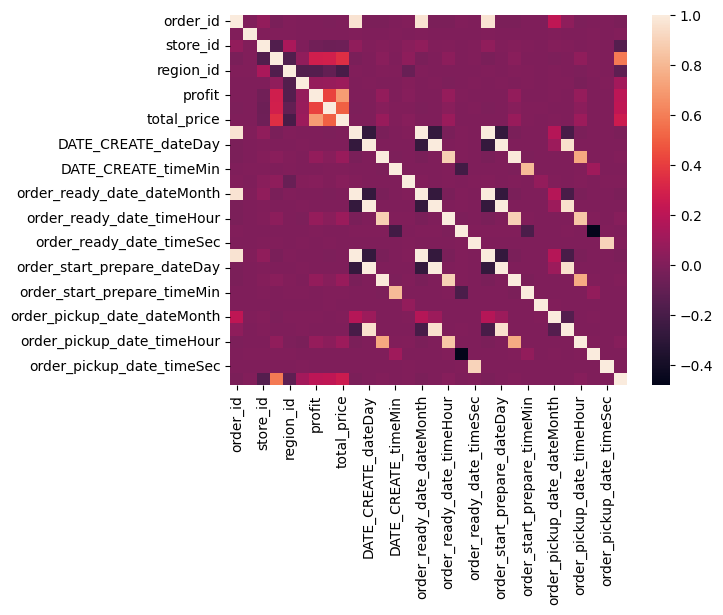

In [85]:
import seaborn as sns
order_train['real_prep_time'] = y_train
fig = sns.heatmap(order_train.corr())
order_train.drop(columns=['real_prep_time'], inplace=True)
# order_train.style.background_gradient(cmap='Blues',axis=None)

In [86]:
y_train.describe()

count    462439.000000
mean         21.389762
std          11.172824
min           0.000000
25%          13.833333
50%          19.814103
75%          27.233333
max         710.796437
dtype: float64

#### MinMax Scaling or Roubust

In [87]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler
scaler = RobustScaler()
order_train[:] = scaler.fit_transform(order_train)
order_test[:] = scaler.transform(order_test)

/var/folders/yk/_5kpcqj938b7s5sh4_lh5n540000gn/T/ipykernel_27261/3246624399.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.00855009 -1.00854544 -1.00854776 ...  0.97810195  0.9780973
  0.97809963]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  order_train[:] = scaler.fit_transform(order_train)
/var/folders/yk/_5kpcqj938b7s5sh4_lh5n540000gn/T/ipykernel_27261/3246624399.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.45937873  0.53046595 -0.03863003 ...  0.08482676  0.88251693
  0.5742732 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  order_train[:] = scaler.fit_transform(order_train)
/var/folders/yk/_5kpcqj938b7s5sh4_lh5n540000gn/T/ipykernel_27261/3246624399.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will rai

### TASK 1: REGRESSION TASK - PREDICTING PREPARATION TIME

#### Train the Model

Linear Regression

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics


regressor = LinearRegression().fit(order_train,y_train)
y_pred_lr = regressor.predict(order_test)

print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print('Mean Squared Error:',metrics.mean_squared_error(y_test, y_pred_lr))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('R2:', metrics.r2_score(y_test, y_pred_lr))

Root Mean Squared Error: 7.071295526104835
Mean Squared Error: 50.00322041751026
Mean Absolute Error: 4.059824425801293
R2: 0.5714820587959788


Print coeffs from linear regression

In [89]:
# Logistic Regression Coefficients
print("----Linear Regression Coefficients----")
print(*[a for a in zip(list(order_train.columns), regressor.coef_)], sep='\n')

----Linear Regression Coefficients----
('order_id', 9.707661798940842)
('STATUS_ID', 5.7720781848613125)
('store_id', -0.7449438844043574)
('planned_prep_time', 4.619044532432659)
('region_id', -0.005588832776840439)
('delivery_distance', 0.6581679152587923)
('profit', 0.04604929138063265)
('product_count', 0.21826154142134593)
('total_price', 0.2795035677665366)
('DATE_CREATE_dateMonth', 884.755186406341)
('DATE_CREATE_dateDay', 399.03576042605863)
('DATE_CREATE_timeHour', 8.379642731593808)
('DATE_CREATE_timeMin', 0.5636302799028541)
('DATE_CREATE_timeSec', -0.3195375475315459)
('order_ready_date_dateMonth', 16766.621815485876)
('order_ready_date_dateDay', 7642.354066517803)
('order_ready_date_timeHour', 159.40560677267453)
('order_ready_date_timeMin', 11.359347570306245)
('order_ready_date_timeSec', 0.21199984065134347)
('order_start_prepare_dateMonth', -17656.8292970502)
('order_start_prepare_dateDay', -8043.704908585208)
('order_start_prepare_timeHour', -167.86496574325892)
('orde

In [90]:
# ev_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
# corrupted_data = ev_df[ev_df['Predicted'] < 0]
# corrupted_data

Use Lasso Regressor

Tuning hyper-paramter alpha using TimeSeriesSplit

Aplha: 0.01 losses [88.38208262696547, 78.21508930596548, 77.5476107848717, 75.85946857545974, 77.73803955071403]
Aplha: 0.05 losses [88.33544097140877, 78.20125230293813, 77.51851623222575, 75.7826887141429, 77.65315443026422]
Aplha: 0.09 losses [88.34189701790075, 78.1998190880553, 77.52542173497191, 75.78237525617176, 77.67068907772989]
Aplha: 0.1 losses [88.35037139754549, 78.20657413260678, 77.53372854842651, 75.78885354856935, 77.68001559826989]
Aplha: 0.5 losses [89.7698519615392, 79.46513653403231, 78.70217988330252, 76.74005369301219, 78.79082938150087]
Aplha: 1 losses [91.8217672023395, 81.56833681392885, 80.61113639397776, 78.47109616956293, 80.6971064764749]


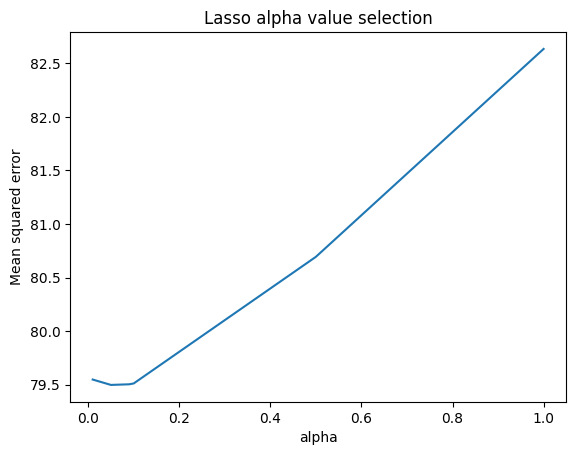

Best value of alpha: 0.05


In [91]:
from sklearn.linear_model import Lasso

alphas = [0.01, 0.05 , 0.09, 0.1, 0.5, 1]
losses = []
tscv = TimeSeriesSplit(n_splits=5)

for alpha in alphas:
    fold_losses = []  # to store loss for each fold
    for train_index, test_index in tscv.split(order_train):
        # Split data into training and validation sets
        X_train, X_val = order_train.iloc[train_index], order_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Initialize Lasso model with the current alpha value
        lasso = Lasso(alpha=alpha)
        
        # Fit the model on the training set
        lasso.fit(X_train, y_train_fold)
        
        # Predict on the validation set
        y_pred_val = lasso.predict(X_val)
        
        # Calculate mean squared error and store it
        mse = metrics.mean_squared_error(y_val_fold, y_pred_val)
        fold_losses.append(mse)

    print(f'Aplha: {alpha} losses {fold_losses}')
    avg_loss = np.mean(fold_losses)
    losses.append(avg_loss)

    # lasso = Lasso(alpha)
    # lasso.fit(order_train, y_train)
    # y_pred_val = lasso.predict(order_test)
    # losses.append( metrics.mean_squared_error(y_test,y_pred_val))

plt.plot(alphas, losses)
plt.title("Lasso alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

Use  alpha = 0.05 for our lasso model and print metrics 

In [92]:
lasso = Lasso(alpha=0.05).fit(order_train, y_train)
y_pred_lasso = lasso.predict(order_test)

print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))
print('Mean Squared Error:',metrics.mean_squared_error(y_test, y_pred_lasso))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lasso))
print('R2:', metrics.r2_score(y_test, y_pred_lasso))

Root Mean Squared Error: 8.732880244533764
Mean Squared Error: 76.2631973653681
Mean Absolute Error: 6.335438117408139
R2: 0.3464391282846365


Note : results are worse, try adding polynomial features then use lasso

Print coeffs from lasso model

In [93]:
# Lasso Regularization Coefficients
print("----Lasso Coefficients----")
print(*[a for a in zip(list(order_train.columns), lasso.coef_)], sep='\n')

----Lasso Coefficients----
('order_id', 0.0)
('STATUS_ID', 0.0)
('store_id', -1.0842832531486903)
('planned_prep_time', 7.388634015210627)
('region_id', -0.0)
('delivery_distance', 0.9851193601057588)
('profit', 0.04718590276714767)
('product_count', 0.30344422890070366)
('total_price', 0.4443655493896012)
('DATE_CREATE_dateMonth', 0.0)
('DATE_CREATE_dateDay', -0.0)
('DATE_CREATE_timeHour', -0.0)
('DATE_CREATE_timeMin', -0.0)
('DATE_CREATE_timeSec', -0.3466073270191593)
('order_ready_date_dateMonth', 0.0)
('order_ready_date_dateDay', -0.0)
('order_ready_date_timeHour', -0.0)
('order_ready_date_timeMin', -0.0)
('order_ready_date_timeSec', 0.0)
('order_start_prepare_dateMonth', 0.0)
('order_start_prepare_dateDay', -0.0)
('order_start_prepare_timeHour', -0.06134191428541841)
('order_start_prepare_timeMin', -0.0)
('order_start_prepare_timeSec', -0.0)
('order_pickup_date_dateMonth', -0.0)
('order_pickup_date_dateDay', -0.0)
('order_pickup_date_timeHour', -0.010599594603099215)
('order_picku

#### Use ANN

Convert to torch

In [94]:
import torch

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(order_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values).float()

X_test_tensor = torch.from_numpy(order_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float()

# X_train_tensor = torch.tensor(order_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(order_test, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Create Dataset and DataLoader

In [95]:
from torch.utils.data import Dataset, DataLoader

class OrdersDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the dataset
train_dataset = OrdersDataset(X_train_tensor, y_train_tensor)
test_dataset = OrdersDataset(X_test_tensor, y_test_tensor)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


Create neural network class

In [96]:
import torch.nn as nn

class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 8)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x

# Initialize the model
input_dim = order_train.shape[1]
model = ANNModel(input_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Model

In [97]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Clear gradients from the previous iteration

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 128.0521425497423
Epoch 2/100, Loss: 127.2896643305234
Epoch 3/100, Loss: 125.2367855649294
Epoch 4/100, Loss: 125.08419256754077
Epoch 5/100, Loss: 124.98132631331971
Epoch 6/100, Loss: 124.86509040092913
Epoch 7/100, Loss: 124.74470807085267
Epoch 8/100, Loss: 124.65677304760162
Epoch 9/100, Loss: 124.60448124122989
Epoch 10/100, Loss: 124.56653524335982
Epoch 11/100, Loss: 124.53709564676187
Epoch 12/100, Loss: 124.5091895542414
Epoch 13/100, Loss: 124.48667981371865
Epoch 14/100, Loss: 124.46357277176764
Epoch 15/100, Loss: 124.44999955982638
Epoch 16/100, Loss: 124.4417934403207
Epoch 17/100, Loss: 124.43238684097024
Epoch 18/100, Loss: 124.42525843797942
Epoch 19/100, Loss: 124.41873945874453
Epoch 20/100, Loss: 124.41497364896769
Epoch 21/100, Loss: 124.40729183890699
Epoch 22/100, Loss: 124.40375356492065
Epoch 23/100, Loss: 124.43057183773274
Epoch 24/100, Loss: 124.40522610761768
Epoch 25/100, Loss: 124.39817259933953
Epoch 26/100, Loss: 124.39351768741771


Evaluate Model

In [98]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    y_pred = []
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        y_pred.append(predictions)

# Concatenate the predictions and convert to numpy for further analysis
y_pred_nn = torch.cat(y_pred).numpy()

print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn)))
print('Mean Squared Error:',metrics.mean_squared_error(y_test, y_pred_nn))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_nn))
print('R2:', metrics.r2_score(y_test, y_pred_nn))

Root Mean Squared Error: 10.495168013561148
Mean Squared Error: 110.14855163287704
Mean Absolute Error: 7.9495799308213
R2: 0.056048186932447064


#### Visualization

Plot relationship between predicted and actual values

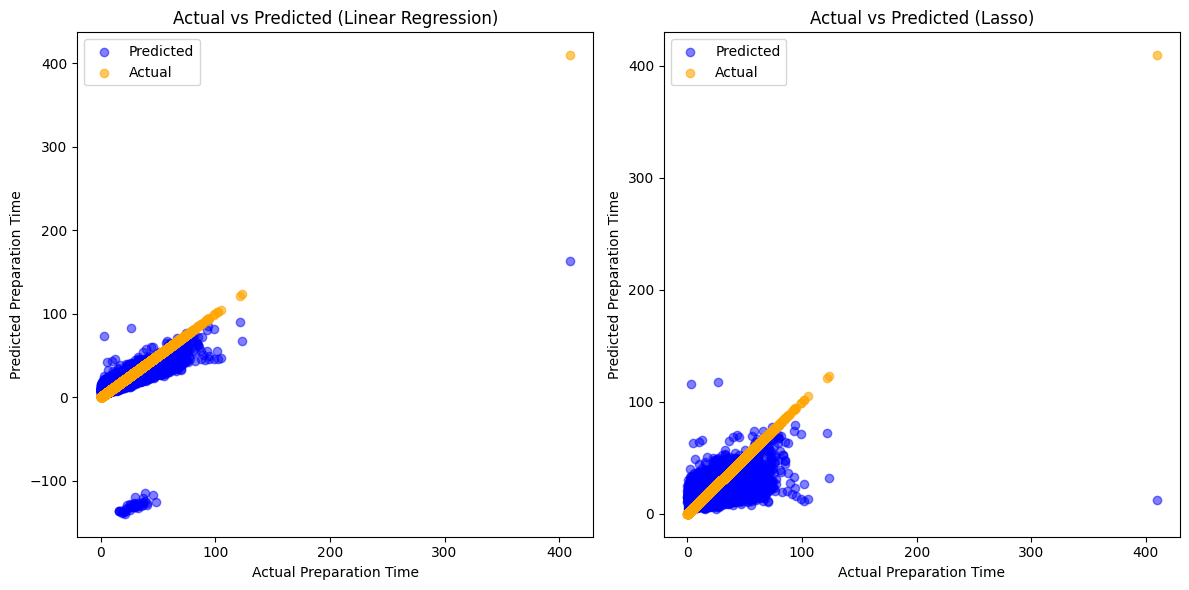

In [99]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))  # Create a figure with a custom size

# First subplot for Model 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.scatter(y_test, y_pred_lr, color='blue', label='Predicted', alpha=0.5)  # Plot predictions
plt.scatter(y_test, y_test, color='orange', label='Actual', alpha=0.6)    # Plot actual values

# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Prediction')  # Diagonal line
plt.xlabel('Actual Preparation Time')
plt.ylabel('Predicted Preparation Time')
plt.title(f'Actual vs Predicted (Linear Regression)')
plt.legend()

# Second subplot for Model 2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.scatter(y_test, y_pred_lasso, color='blue', label='Predicted', alpha=0.5)  # Plot predictions
plt.scatter(y_test, y_test, color='orange', label='Actual', alpha=0.6)    # Plot actual values
plt.xlabel('Actual Preparation Time')
plt.ylabel('Predicted Preparation Time')
plt.title(f'Actual vs Predicted (Lasso)')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()



Function for plotting weights of feature from model 

In [100]:
def plot_coeffs(regressor):
    coefficients = regressor.coef_
    features = order_train.columns
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': coefficients
    })

    # Sort the features by the absolute value of the coefficients
    coef_df['abs_coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

    # Plot the coefficients
    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Most Significant Features Affecting Preparation Time')
    plt.gca().invert_yaxis()
    plt.show()

Plot coefficients of linear regressor

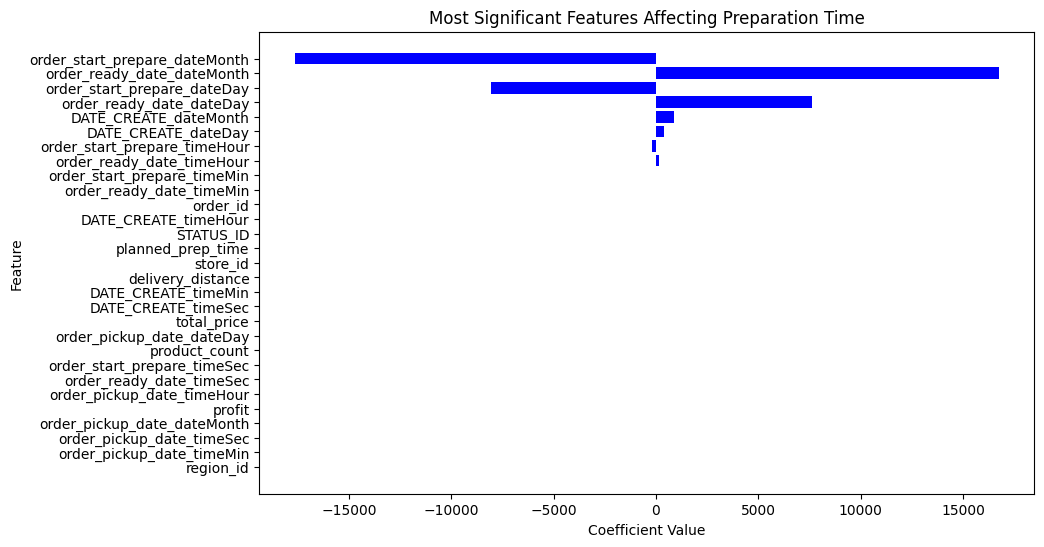

In [101]:
plot_coeffs(regressor=regressor)

Plot coefficients of lasso

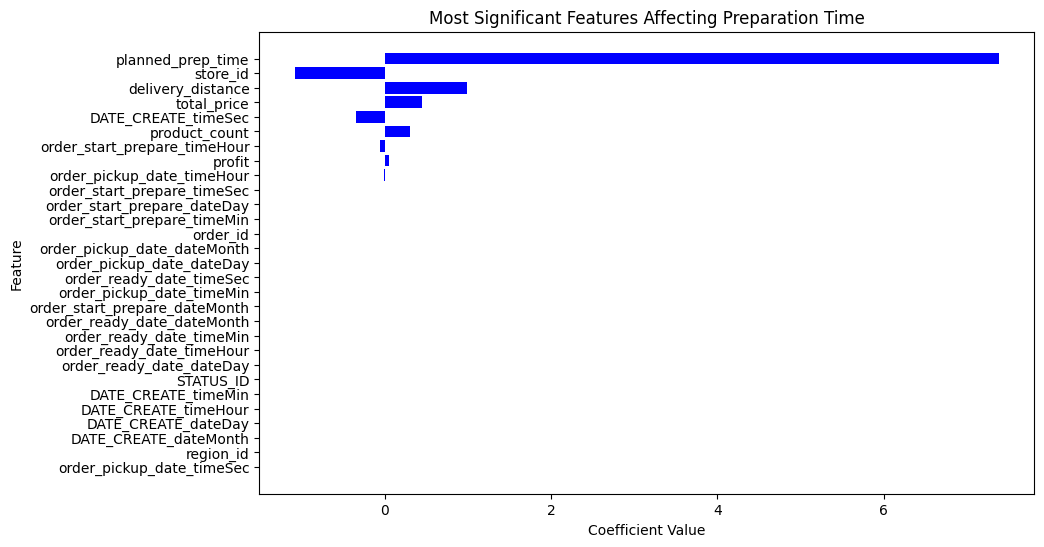

In [102]:
plot_coeffs(regressor=lasso)

### TASK 2: CLASSIFICATION TASK - PREDICTING ON-TIME COMPLETION

#### Remove outliers and balance the dataset

Remove outliers and balance the dataset: Implement outlier detection techniques (e.g.,
Z-score, IQR, or isolation forests) to identify and handle these outliers. Balance the dataset
using one of the following techniques

Visualise outlier

<Figure size 1500x500 with 0 Axes>

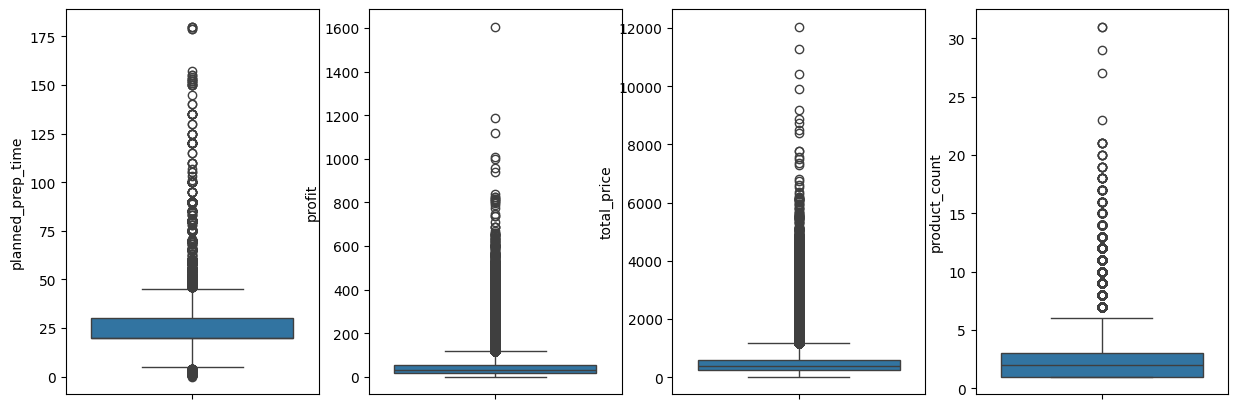

In [103]:
'''No outliers in product_count'''
cols_to_remove_outliers = ['planned_prep_time','profit','total_price','product_count']

plt.figure(figsize=(15, 5))
fig,axes = plt.subplots(1, len(cols_to_remove_outliers), figsize=(15,5))
for i,col in enumerate(cols_to_remove_outliers):
    sns.boxplot(y=order_df_task_2[col],ax=axes[i])

#### Remove outliers
remove outliers form most significant features using IQR and Balance the dataset

In [104]:
for col in ['profit','total_price']:
    Q1 = order_df_task_2[col].quantile(0.25)
    Q3 = order_df_task_2[col].quantile(0.75)
    IQR = Q3 - Q1
    order_df_task_2.query(f'(@Q1 - 1.5 * @IQR) <= {col} <= (@Q3 + 1.5 * @IQR)',inplace=True)

In [105]:
order_df_task_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411542 entries, 0 to 517609
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             411542 non-null  int64         
 1   STATUS_ID            411542 non-null  object        
 2   store_id             411542 non-null  int64         
 3   planned_prep_time    411542 non-null  float64       
 4   DATE_CREATE          411542 non-null  datetime64[ns]
 5   region_id            411542 non-null  int64         
 6   order_ready_date     370519 non-null  datetime64[ns]
 7   order_start_prepare  370342 non-null  datetime64[ns]
 8   delivery_distance    411542 non-null  int64         
 9   profit               411542 non-null  float64       
 10  order_pickup_date    411542 non-null  datetime64[ns]
 11  product_count        411542 non-null  int64         
 12  total_price          411542 non-null  float64       
dtypes: datetime64[ns](4

Plot boxplot after balancing

<Figure size 1500x500 with 0 Axes>

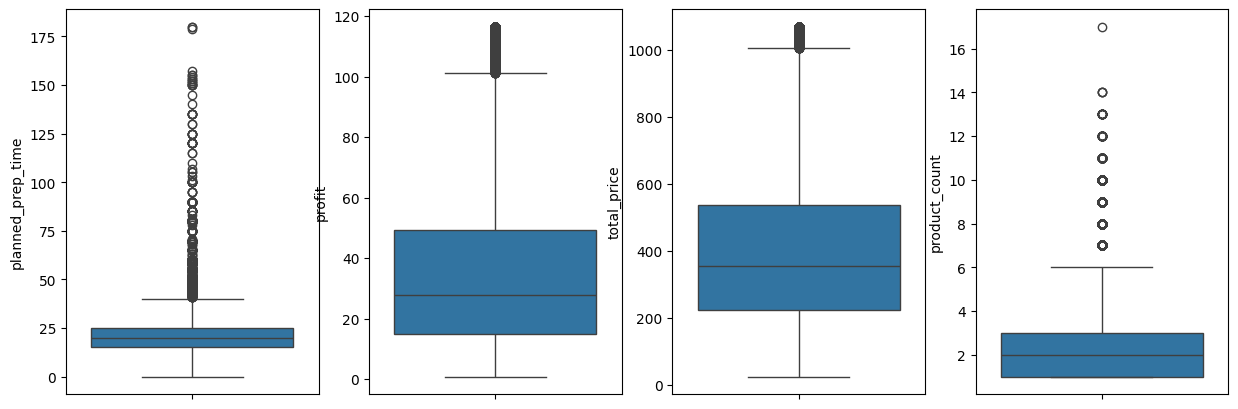

In [106]:
plt.figure(figsize=(15, 5))
fig,axes = plt.subplots(1, len(cols_to_remove_outliers), figsize=(15,5))
for i,col in enumerate(cols_to_remove_outliers):
    sns.boxplot(y=order_df_task_2[col],ax=axes[i])

#### Apply pre-processing steps from task 1

split the dataset to test and train

In [107]:
order_df_task_2.sort_values(by='DATE_CREATE',inplace=True)
order_train, order_test = train_test_split(order_df_task_2,shuffle=False,test_size=.1)

Fill `order_start_prepare` and `order_ready`

In [108]:
fill_order_start_prepare(order_train)
fill_order_ready_date(order_train)

fill_order_start_prepare(order_test)
fill_order_ready_date(order_test)

drop data where `order_ready_date` is before `order_start_prepare`

drop rows with null `order_ready_date` or `order_start_prepare`

In [109]:
drop_corrupted_data(order_train)
drop_corrupted_data(order_test)

order_train.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)
order_test.dropna(subset=['order_ready_date','order_start_prepare'],inplace=True)

In [110]:
order_test.isna().sum()

order_id               0
STATUS_ID              0
store_id               0
planned_prep_time      0
DATE_CREATE            0
region_id              0
order_ready_date       0
order_start_prepare    0
delivery_distance      0
profit                 0
order_pickup_date      0
product_count          0
total_price            0
dtype: int64

Calculate labels

if absolute difference between `planned_prep_minutes` and
`order_ready_time` - `order_prep_start` is greater than 5 minutes then the order is not
prepared on time

In [111]:
real_prep_time_train = (order_train.order_ready_date - order_train.order_start_prepare) / pd.Timedelta(minutes=1)
y_train =  ((order_train.planned_prep_time - real_prep_time_train).abs() <= 5).map(int)
real_prep_time_test = (order_test.order_ready_date - order_test.order_start_prepare) / pd.Timedelta(minutes=1)
y_test = ((order_test.planned_prep_time - real_prep_time_test).abs() <= 5).map(int)

Extract date features

In [112]:
extract_date_feats(order_train)
extract_date_feats(order_test)

Encode `status_id`

In [113]:
target_encoding = {'F': 0, 'C': 1}
order_test['STATUS_ID'] = order_test.STATUS_ID.apply(lambda x: target_encoding[x])
order_train['STATUS_ID'] = order_train.STATUS_ID.apply(lambda x: target_encoding[x])

Scale the data using `RobustScaler`

In [114]:
from sklearn.preprocessing import RobustScaler,StandardScaler

transformer = RobustScaler().fit(order_train)
transformer.transform(order_train)
transformer.transform(order_test)

array([[ 0.97722505,  0.        ,  0.01843499, ...,  0.57142857,
         0.63333333, -0.53333333],
       [ 0.97712028,  0.        , -0.56226711, ...,  0.71428571,
        -0.4       ,  0.76666667],
       [ 0.97723669,  0.        ,  0.74249853, ...,  0.57142857,
         0.56666667,  0.3       ],
       ...,
       [ 1.19249744,  0.        ,  0.90606001, ...,  0.        ,
        -0.76666667,  0.3       ],
       [ 1.19253237,  0.        , -0.46067856, ...,  0.        ,
        -0.86666667,  0.7       ],
       [ 1.19254168,  0.        , -0.23357521, ...,  0.        ,
        -0.96666667, -0.96666667]])

#### Train a classification model

Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression

# fit Logistic Regression
clf = LogisticRegression(random_state=0,max_iter=1000).fit(order_train, y_train)
y_test_pred = clf.predict(order_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))
print('F1 score = {}'.format(metrics.f1_score(y_test, y_test_pred)))

Testing accuracy = 0.5647078970545063
Testing precision = 0.553354272368527
Testing recall = 0.3593995187781149
F1 score = 0.43576977960995716


View coefficients

In [116]:
# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(order_train.columns), clf.coef_[0])], sep='\n')

----Logistic Regression Coefficients----
('order_id', -4.1052870891925973e-08)
('STATUS_ID', -8.007695345321696e-07)
('store_id', -7.468370407957894e-06)
('planned_prep_time', -0.039633494646600806)
('region_id', 0.002487172269342135)
('delivery_distance', -1.6172140897907894e-05)
('profit', 0.000769826830413398)
('product_count', -0.000707832791704058)
('total_price', 0.00032269950796667813)
('DATE_CREATE_dateMonth', 0.0005961601411671054)
('DATE_CREATE_dateDay', -0.00024431437483141344)
('DATE_CREATE_timeHour', -0.0002668574548580081)
('DATE_CREATE_timeMin', -7.060415916522397e-06)
('DATE_CREATE_timeSec', -0.0007350220295414764)
('order_ready_date_dateMonth', 0.0005965454767601675)
('order_ready_date_dateDay', -0.00023498116494270117)
('order_ready_date_timeHour', -0.0006886265643061358)
('order_ready_date_timeMin', -0.0012001379676472711)
('order_ready_date_timeSec', -0.00019659798760552106)
('order_start_prepare_dateMonth', 0.0005960251456978571)
('order_start_prepare_dateDay', -0.

Plot treshhold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

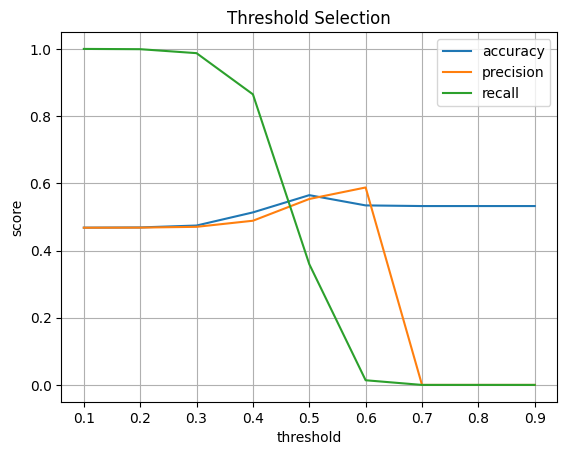

In [117]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = clf.predict_proba(order_test)

results = [[], [], []]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))  # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr))  # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr))  # recall

plt.plot(thresholds, results[0], label='accuracy')
plt.plot(thresholds, results[1], label='precision')
plt.plot(thresholds, results[2], label='recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

Calculate confision matrix

In [118]:
def calc_confusion_matrix(true_labels, pred_labels):
    """Compute confusion matrix to evaluate the accuracy of a classification
    
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    pred_labels : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    num_labels = np.unique(true_labels).size
    cm = np.zeros((num_labels, num_labels), dtype=int)
    for a, p in zip(true_labels, pred_labels):
        cm[a][p] += 1
    return cm

In [119]:
calc_confusion_matrix(y_test,y_test_pred)

array([[16212,  5546],
       [12247,  6871]])

#### Try SVM

In [120]:
# from sklearn.svm import SVC

# model = SVC(kernel='linear')
# model.fit(order_train, y_train)
# y_pred_svc = model.predict(order_test)

# # calculate metrics
# print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_svc)))
# print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred_svc)))
# print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred_svc)))